In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uhack-sentiments-20-decode-code-words/Dataset Description.xlsx
/kaggle/input/uhack-sentiments-20-decode-code-words/Participants_Data_DCW/submission.csv
/kaggle/input/uhack-sentiments-20-decode-code-words/Participants_Data_DCW/train.csv
/kaggle/input/uhack-sentiments-20-decode-code-words/Participants_Data_DCW/test.csv


In [2]:
!pip install simpletransformers

     |████████████████████████████████| 247 kB 518 kB/s            
     |████████████████████████████████| 43 kB 1.5 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 9.2 MB 5.8 MB/s            
     |████████████████████████████████| 82 kB 1.1 MB/s             
     |████████████████████████████████| 76 kB 4.5 MB/s             
     |████████████████████████████████| 4.3 MB 61.2 MB/s            
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=e3639643de6a893af732cbc932a8d1d252b049e11228312a0509a6af5954cbfb
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: Click
    Found existing installation: click 8.0.3
    Uninstalling click-8.0.3:
      Successfully uninstalled click-8.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This 

In [3]:
import numpy as np
import pandas as pd
from simpletransformers.classification.classification_model import ClassificationModel
from simpletransformers.classification import MultiLabelClassificationModel
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import *

In [4]:
root_path = '/kaggle/input/uhack-sentiments-20-decode-code-words/Participants_Data_DCW/'
train = pd.read_csv(root_path+'train.csv',engine='python')
test = pd.read_csv(root_path+'test.csv')
sub = pd.read_csv(root_path+'submission.csv')

In [5]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
punctuation=string.punctuation
from bs4 import BeautifulSoup
!pip install emoji
!pip install num2words
import emoji
import string
punctuation=string.punctuation
from num2words import num2words
# !pip install pyspellchecker

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     |████████████████████████████████| 101 kB 694 kB/s           


In [6]:
# test['Review'].apply(lambda x : len(x.split())).value_counts()

In [7]:
def get_split(text1):
    l_total = []
    l_parcial = []
    print(len(text1.split()))
    if len(text1.split())//250 >0:
        n = len(text1.split())//250
    else: 
        n = 1
    print(n)
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:300]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*250:w*250 + 300]
            l_total.append(" ".join(l_parcial))
    return l_total



# train['Review'].apply(get_split)

In [8]:
train['Review'].apply(len).value_counts()

61      57
50      55
27      55
39      55
35      55
        ..
905      1
1231     1
949      1
555      1
522      1
Name: Review, Length: 683, dtype: int64

In [9]:

# Most common usage.
print(num2words(36))

tx = 'Purchased 3 of these. They are clear and have a good picture. Identifying a person or license plate tho is limited to about 20 feet out. All in all they do a good job. The cameras can be a bit temperamental but not uncommon with anything running on wi-fi'

def numtowords(tx):
    ft = tx.split()
    for k in range(len(ft)):
        if ft[k].isdigit():
            ft[k] = num2words(int(ft[k]))
    return " ".join(ft)
numtowords(tx)


from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
from nltk.corpus import wordnet
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def stem_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])




thirty-six


In [10]:


def random_seed(seed_value):
    import random 
    random.seed(seed_value) # Python
    import numpy as np
    np.random.seed(seed_value) # cpu vars
    import torch
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
def url_to_words(raw_text):
    raw_text=str(raw_text).strip()
#     soup = BeautifulSoup(raw_text, 'html.parser')
#     raw_text = soup.text
#     raw_text = emoji.demojize(raw_text)
#     no_coms=re.sub(r'\.com','',raw_text)
#     no_urls=re.sub('https?://www','',no_coms)
#     no_urls1=re.sub('https?://','',no_urls)
#     try:
#         no_encoding=no_urls1.decode("utf-8-sig").replace(u"\ufffd", "?")
#     except:
#         no_encoding = no_urls1
    letters_only = re.sub("[^a-zA-Z0-9]", " ",raw_text) 
#     words = letters_only.split()                             
#     stops = set(stopwords.words("english"))                  
#     meaningful_words = [w.lower() for w in words if w not in stops] 
    return letters_only
#     return( " ".join( meaningful_words ))

random_seed(2021)

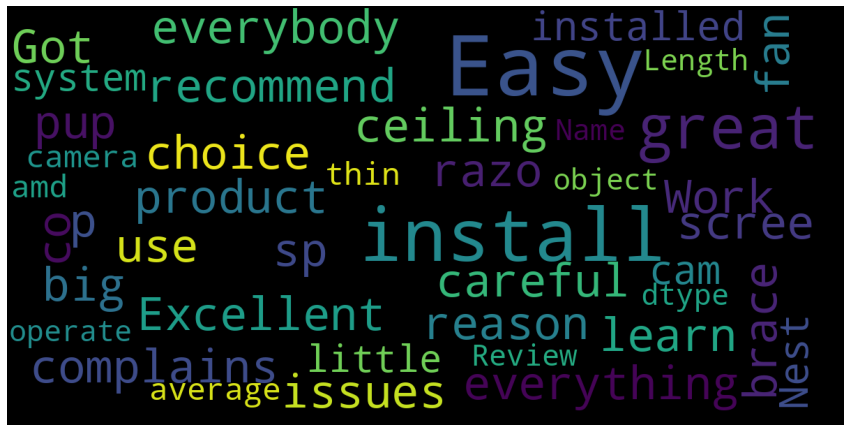

In [11]:
from wordcloud import WordCloud, STOPWORDS
stopwords1 = set(STOPWORDS)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords1,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(train['Review'])

In [12]:
train['Review'].sample(20).values

array(['Did not cut straight. Too much hand strength required to cut 3/4, 1".',
       'The fan electrical box was easy to install and our fan a solid support.',
       'Easy to setup and works very well, I would buy it again',
       'Works good, perfect size.',
       "My house have 4 toilets by Kohler Thanks for the good products Kohler have  I'm 200% happy with all my toilets works amazing",
       'What can you say...brad nails that work in the nail gun without jamming. Good price. I use them in a ryobi nailer with no issues.',
       'This hose nozzle is sturdy, has a little bit of weight to it and lots of control. I use the mist, shower and jet functions quite often, although there are several others.  Each function has a low to high that allows quite a lot of variation. The shower beats any wand waterer, because you have a choice of light to heavy shower and everything in-between. The mist is great for newly planted seed trays for instance. I use the jet spray to clean my pond 

In [13]:
target = ['Components', 'Delivery and Customer Support',
       'Design and Aesthetics', 'Dimensions', 'Features', 'Functionality',
       'Installation', 'Material', 'Price', 'Quality', 'Usability',
       'Polarity']

In [14]:
for k in target:
    print(train[k].value_counts())

0    5862
1     274
Name: Components, dtype: int64
0    5957
1     179
Name: Delivery and Customer Support, dtype: int64
0    5486
1     650
Name: Design and Aesthetics, dtype: int64
0    5441
1     695
Name: Dimensions, dtype: int64
0    5823
1     313
Name: Features, dtype: int64
0    3598
1    2538
Name: Functionality, dtype: int64
0    5374
1     762
Name: Installation, dtype: int64
0    5981
1     155
Name: Material, dtype: int64
0    5282
1     854
Name: Price, dtype: int64
0    3959
1    2177
Name: Quality, dtype: int64
0    4907
1    1229
Name: Usability, dtype: int64
1    4770
0    1366
Name: Polarity, dtype: int64


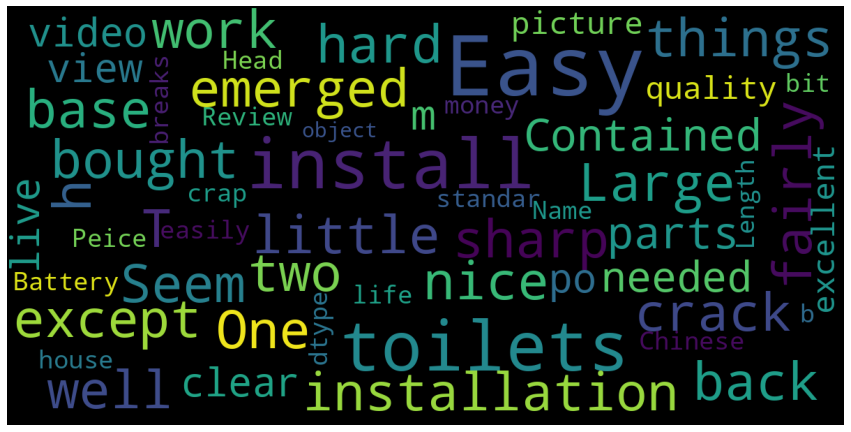

In [15]:
show_wordcloud(train[train['Components']==1]['Review'])

In [16]:
tr = pd.DataFrame()




tr['text'] = train['Review'].apply(url_to_words).apply(lambda x: x.lower())


tr['labels'] =train[target].apply(lambda x : list(x),axis=1)

<AxesSubplot:>

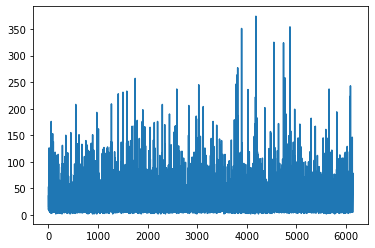

In [17]:
train['Review'].apply(lambda x: len(x.split())).plot()

<AxesSubplot:>

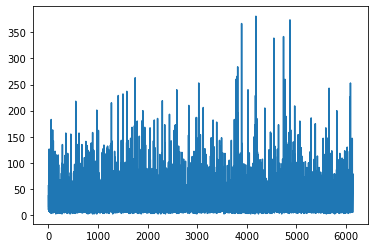

In [18]:
tr['text'].apply(lambda x: len(x.split())).plot()

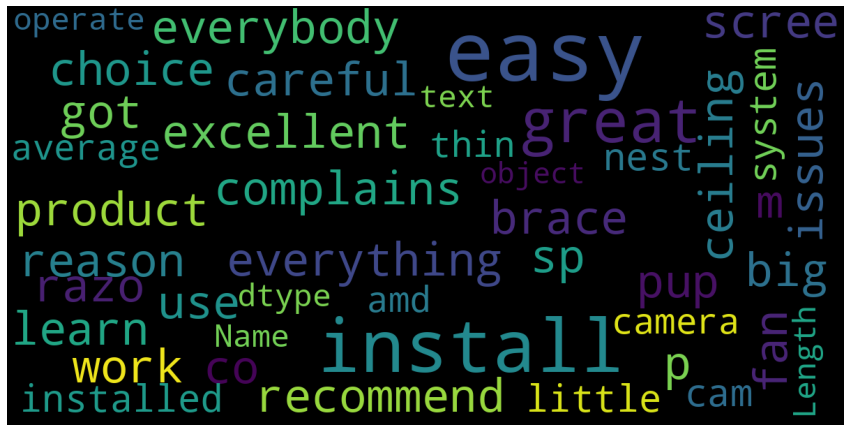

In [19]:
show_wordcloud(tr['text'])

In [20]:
test['Review'] = test['Review'].apply(url_to_words).apply(lambda x: x.lower())
ts=pd.DataFrame()
ts['text']=test['Review']
ts['labels'] = [[0]*len(target)]*len(ts)

In [21]:
y=tr['labels']


In [22]:
# df=tr.append(ts,ignore_index=True)
# from collections import Counter
# cnt = Counter()
# for text in df["text"].values:
#     for word in text.split():
#         cnt[word] += 1
        
# # print(cnt.most_common(50))


# # FREQWORDS = set([w for (w, wc) in cnt.most_common(50)])
# # def remove_freqwords(text):
# #     """custom function to remove the frequent words"""
# #     return " ".join([word for word in str(text).split() if word not in FREQWORDS])

# # df["Review"] = df["Review"].apply(lambda text: remove_freqwords(text))
# # df.head()




# n_rare_words = 50
# RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
# COMMONWORDS = set([w for (w, wc) in cnt.most_common(50)])
# print(RAREWORDS,COMMONWORDS)
# def remove_words(text):
#     """custom function to remove the rare words"""
#     return " ".join([word for word in str(text).split() if word not in list(RAREWORDS)+list(COMMONWORDS)])


In [23]:
# list(RAREWORDS)+list(COMMONWORDS)

In [24]:

# tr["text"] = tr["text"].apply(lambda text: remove_words(text))
# tr["text"] = tr["text"].apply(lambda text: remove_words(text))
# df.head()

<AxesSubplot:>

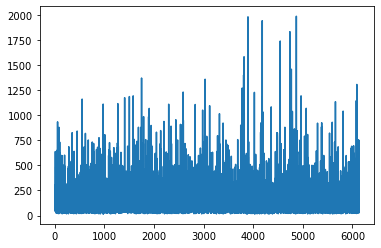

In [25]:
tr['text'].apply(lambda x: len(x)).plot()

In [26]:
tr[tr['text'].apply(lambda x: len(x.split()))>256]['text'].values

array(['i love this sprinkler  for the price and quality it s an incredible buy  i was skeptical of the reviews at first   so many positive and lower priced than a lot of others with a plethora of issues unboxing it wasn t any better it looked pretty basic no major components  actually thought it was probably missing parts  nope  i was wrong  i hooked this thing up to my hose and it worked like a charm  plenty of sprinkler settings to choose from which was great  i was trying to grow grass late in the season and has to move fast  this definitely helped get my lawn across the finish line before the snow fell the fact that it is simple is a testament to its construction and there is less that can go wrong with it as a result  i can actually give testament to its durability  i have a menagerie of wildlife in my backyard including a herd of deer  well went out 1 morning to turn on my sprinkler and it wasn t working  no motion  if the hoof prints in the soft wet soil were any indication   t

In [27]:
ts[ts['text'].apply(lambda x: len(x))>1200]['text'].values

array(['great easy to use app  add new devices by simply scanning a qrc code  sets up in a couple of minutes  nice customizable control settings for motion detection zones  lights  video    notifications  you can link devices so if one device detects motion other devices will start recording  linking chimes are easy the app even gives you device health status  easy to snooze motion if you are working outside  you can manually turn on the lights and a siren too if you like  easy to replay and save videos  i like the people only motion sensitivity mode but not the color night vision  it makes the video look odd with the colors added 1  the installation is easy and instructions are accurate  well thought out  except for one glaring omission  i would bet most people who buy the wired camera drill a hole through the house and plug it in at the garage door opener outlet  the problem is that the plug is giant and nobody wants to drill a giant hole  probably at least 11 4    in their wall to p

<AxesSubplot:>

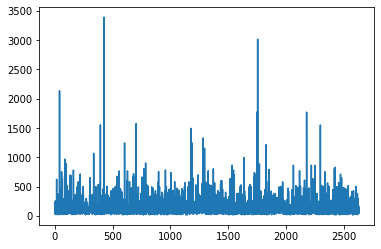

In [28]:
ts['text'].apply(lambda x: len(x)).plot()

In [29]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab
import operator 

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words


vocab = build_vocab(tr['text'])
test_vocab = build_vocab(ts['text'])
oov_glove = check_coverage(test_vocab,vocab)

Found embeddings for 75.35% of vocab
Found embeddings for  98.13% of all text


In [30]:
# oov_glove

In [31]:
tcxt = [x[0] for x in oov_glove]

In [32]:
tcxt[:100]

['niagara',
 'vents',
 'flew',
 'gripping',
 'continually',
 'measurement',
 'ove',
 'accessory',
 'stole',
 'scare',
 'anderson',
 'jared',
 'brighten',
 'heights',
 'condo',
 'mailbox',
 'potentially',
 'minimize',
 'disassemble',
 'tables',
 'daylight',
 'underlayment',
 'coral',
 'impulse',
 'lovely',
 'dissatisfied',
 'taped',
 'nasty',
 'hail',
 'cosmetic',
 'curves',
 'cradle',
 'rests',
 'twelve',
 'grnd',
 'reboot',
 'unexpected',
 'seek',
 'az',
 'prefers',
 'whistles',
 '2k',
 '2g',
 'sleeve',
 'bubbling',
 'manager',
 'speaking',
 'headrest',
 '78',
 'canada',
 'reattached',
 'totos',
 'crushing',
 'amp',
 'regions',
 'upgrading',
 'mountain',
 'redwood',
 'railings',
 'rotted',
 'pixelated',
 'mar',
 'tufted',
 'liner',
 '2016',
 'networks',
 'drives',
 'solo',
 'saturates',
 'tedious',
 'chewed',
 'imho',
 'dewault',
 'markings',
 'aesthetically',
 'flaps',
 'esp',
 'raccoons',
 'barrier',
 'vapour',
 'association',
 'rectangle',
 'summary',
 'unclogging',
 'beach',
 'for

In [33]:
# tr['text'].apply(lambda x: " ".join([f for f in x.split() if f not in tcxt]))

vocab = build_vocab(tr['text'])
test_vocab = build_vocab(ts['text'].apply(lambda x: " ".join([f for f in x.split() if f not in tcxt[:100]])))
oov_glove = check_coverage(test_vocab,vocab)

Found embeddings for 76.78% of vocab
Found embeddings for  98.42% of all text


In [34]:
ts['text'] = ts['text'].apply(lambda x: " ".join([f for f in x.split() if f not in tcxt]))

In [35]:
!pip install iterative-stratification

In [36]:

from sklearn.model_selection import train_test_split


train_df, eval_df = train_test_split(tr, test_size=0.2)

random_seed(2021)
def getmodel2():
    model = MultiLabelClassificationModel('roberta','roberta-large',num_labels=len(target), args={
                                                                        'learning_rate': 3e-5,'max_seq_length': 256,
                                                                         'overwrite_output_dir':True,'reprocess_input_data':True,"save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,'silent':False,'manual_seed':2021,'no_cache':True,
                                                                         'num_train_epochs': 7,'use_early_stopping':True,
#         ,'weight_decay':0.05,'use_early_stopping':True,'early_stopping_metric':log_loss,
                                                                        }) 
    return model
# model=getmodel2()
# model.train_model(train_df)

In [37]:
# model.predict(eval_df['text'])

In [38]:

from sklearn.metrics import log_loss
from scipy.special import softmax
# result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [39]:
# model.args

In [40]:
# print("Log loss",log_loss(eval_df.labels.tolist(),model_outputs))

In [41]:
# preds, outputs = model.predict(to_predict)

In [42]:
# random_seed(1994)
import warnings
warnings.filterwarnings('ignore')

import gc

# model_args.early_stopping_delta = 0.01
# model_args.early_stopping_metric = "mcc"
# model_args.early_stopping_metric_minimize = False
# model_args.early_stopping_patience = 5
# model_args.evaluate_during_training_steps = 1000




from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import KFold,StratifiedKFold
fold=MultilabelStratifiedKFold(n_splits=5,shuffle=True,random_state=1994)
i=1
y_pred_tot=[]
err=[]
for train_index, test_index in fold.split(tr,pd.DataFrame(tr['labels'].tolist())):
    
    X_train, X_test = tr.iloc[train_index], tr.iloc[test_index]
    print(X_train.shape,X_test.shape)
    model=getmodel2()
    gc.collect()
    model.train_model(X_train)
    preds_val = model.eval_model(X_test)[1]
    result, model_outputs, wrong_predictions = model.eval_model(X_test,acc = log_loss)
    print("Log loss",log_loss(X_test.labels.tolist(),model_outputs))
    err.append(log_loss(X_test.labels.tolist(),model_outputs))
    _,test_preds,_ = model.eval_model(ts)
    y_pred_tot.append(test_preds)

(4915, 2) (1221, 2)


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/4915 [00:00<?, ?it/s]

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

  0%|          | 0/1221 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/1221 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/153 [00:00<?, ?it/s]

Log loss 3.079575333746633


  0%|          | 0/2631 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/329 [00:00<?, ?it/s]

(4902, 2) (1234, 2)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight

  0%|          | 0/4902 [00:00<?, ?it/s]

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/155 [00:00<?, ?it/s]

Log loss 2.962769529718964


  0%|          | 0/2631 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/329 [00:00<?, ?it/s]

(4902, 2) (1234, 2)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight

  0%|          | 0/4902 [00:00<?, ?it/s]

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/155 [00:00<?, ?it/s]

Log loss 2.90997017506456


  0%|          | 0/2631 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/329 [00:00<?, ?it/s]

(4907, 2) (1229, 2)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight

  0%|          | 0/4907 [00:00<?, ?it/s]

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/614 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/614 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/614 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/614 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/614 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/614 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/614 [00:00<?, ?it/s]

  0%|          | 0/1229 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/1229 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/154 [00:00<?, ?it/s]

Log loss 3.030246861825736


  0%|          | 0/2631 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/329 [00:00<?, ?it/s]

(4918, 2) (1218, 2)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight

  0%|          | 0/4918 [00:00<?, ?it/s]

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Running Epoch 0 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 1 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 2 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 3 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 4 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 5 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

Running Epoch 6 of 7:   0%|          | 0/615 [00:00<?, ?it/s]

  0%|          | 0/1218 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/1218 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/153 [00:00<?, ?it/s]

Log loss 3.0334717803308116


  0%|          | 0/2631 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/329 [00:00<?, ?it/s]

In [43]:
# X_test['labels'].explode(axis=1)
np.mean(err)

3.003206736137341

In [44]:
# model_outputs

# log_loss(X_test.labels.tolist(),model_outputs)

In [45]:
np.mean(y_pred_tot,0)

array([[1.05621338e-02, 8.89816284e-03, 5.13038635e-03, ...,
        9.74902344e-01, 4.22515869e-03, 5.51776886e-03],
       [1.28116608e-03, 8.75568390e-04, 1.92279816e-03, ...,
        5.10063171e-03, 1.68418884e-03, 9.94335938e-01],
       [2.70729065e-03, 1.42822266e-03, 2.81753540e-03, ...,
        1.08856201e-02, 9.91796875e-01, 9.97363281e-01],
       ...,
       [1.37672424e-03, 1.39350891e-03, 2.19421387e-03, ...,
        9.89550781e-01, 2.24323273e-03, 9.93359375e-01],
       [5.64422607e-03, 6.13250732e-03, 9.68457031e-01, ...,
        9.96484375e-01, 9.58251953e-03, 7.71826172e-01],
       [4.48226929e-03, 2.13661194e-03, 3.52096558e-03, ...,
        1.23336792e-02, 9.86328125e-01, 9.96582031e-01]])

In [46]:
# ts['text'].apply(lambda x: str(x))

In [47]:
# result, model_outputs, wrong_predictions = m.eval_model(tr)

In [48]:
# len(wrong_predictions[0])

In [49]:

# result, model_outputs, wrong_predictions = m.eval_model(ts)
# y_preds

In [50]:
# result

In [51]:
# model_outputs

In [52]:
# softmax(model_outputs)

In [53]:
# test_preds = softmax(model_outputs)
# test_preds

In [54]:
sub

,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2626,0,0,0,0,0,0,0,0,0,0,0,0
2627,0,0,0,0,0,0,0,0,0,0,0,0
2628,0,0,0,0,0,0,0,0,0,0,0,0
2629,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
sub[target]=np.mean(y_pred_tot,0)
sub.head()

,Components,Delivery and Customer Support,Design and Aesthetics,Dimensions,Features,Functionality,Installation,Material,Price,Quality,Usability,Polarity
0,0.010562,0.008898,0.005130,0.066637,0.004716,0.018645,0.008453,0.711279,0.007759,0.974902,0.004225,0.005518
1,0.001281,0.000876,0.001923,0.001203,0.000949,0.997754,0.001173,0.001116,0.002154,0.005101,0.001684,0.994336
2,0.002707,0.001428,0.002818,0.002183,0.002570,0.004415,0.002468,0.001649,0.003137,0.010886,0.991797,0.997363
3,0.001455,0.000695,0.001823,0.001529,0.001348,0.997266,0.001896,0.000882,0.001698,0.002927,0.003932,0.998926
4,0.000964,0.001178,0.002519,0.001729,0.000840,0.001938,0.001567,0.001267,0.002892,0.993555,0.002759,0.996191


In [56]:
sub.shape

(2631, 12)

In [57]:
sub.to_csv('mh-transformers-v10.csv',index=False)